##### 의사결정나무(DT)
- IF-ELSE 방식의 질문에 대한 답변으로 문제를 해결하는 알고리즘
- 피처(특성) 중에서 선택한 기준으로 데이터 분할
1) 엔트로피 (불순도) => 낮아지는 방향
2) 정보이득 : 1-엔트로피
3) 지니계수 : 불평등수치값 => 낮아지는 방향
- 단점 : 과대적합될 가능성 높음, 성능 낮음
- 장점 : 전처리의 영향을 받지  / 직관성 높음 / 피처들 중 주요 피처 확인 가능  
  
- 주의
1) 주요 피처는 데이터 분할을 위한 주요 피처
2) 100% 데이터의 주요 피처가 아닐 수 있음 -> 다른 검사(상관계수, 시각화)와 함께 평가

<hr>

iris.csv

In [3]:
# 1. Load Data
import pandas as pd
irisDF = pd.read_csv('../../DATA/iris.csv')

# 2. Split
# 1)
feature = irisDF.drop(['species'], axis=1)
target = irisDF['species']
# print(feature.shape, target.shape)
# 2)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=11, stratify=target)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


3. 기계학습 진행
- 타깃 데이터 확인 결과 : 3개의 분류
- 학습 유형 : 지도학습 + 분류
1) 분류 알고리즘 : KNN, Logistic Regression, SVC, Decision Tree
- all estimators 로 적합한 걸 찾을 수 있음

In [10]:
# 3-1. 의사결정 알고리즘으로 분류
# 1) Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=11)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

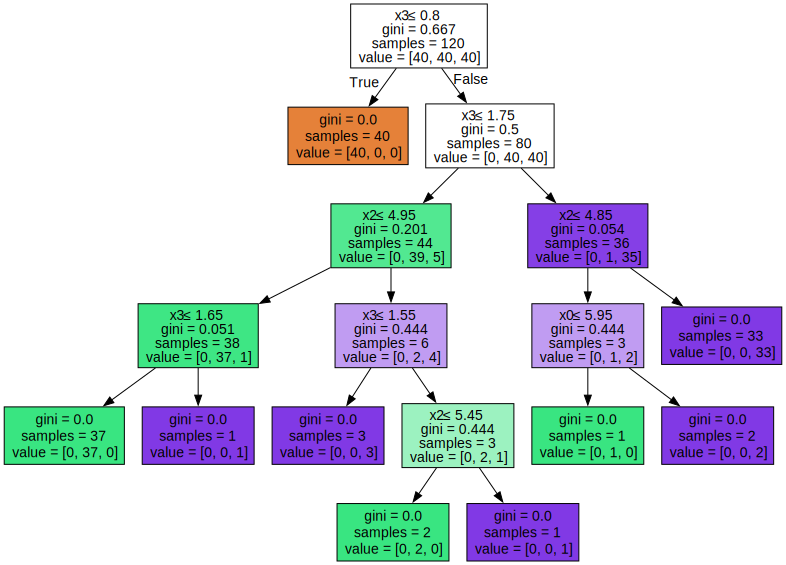

In [16]:
# 3-2. Visualize : export_graphviz
from sklearn.tree import export_graphviz
from graphviz import Source

# 1) Make file : .dot
# print(export_graphviz(model, out_file='tree.txt'))
export_graphviz(model, out_file='iris_dt_model.dot', filled=True, special_characters=True)

# 2) Visualize module from .dot
import graphviz as gv
gv.Source.from_file('iris_dt_model.dot')

# : gini 계수가 높은 값으로 

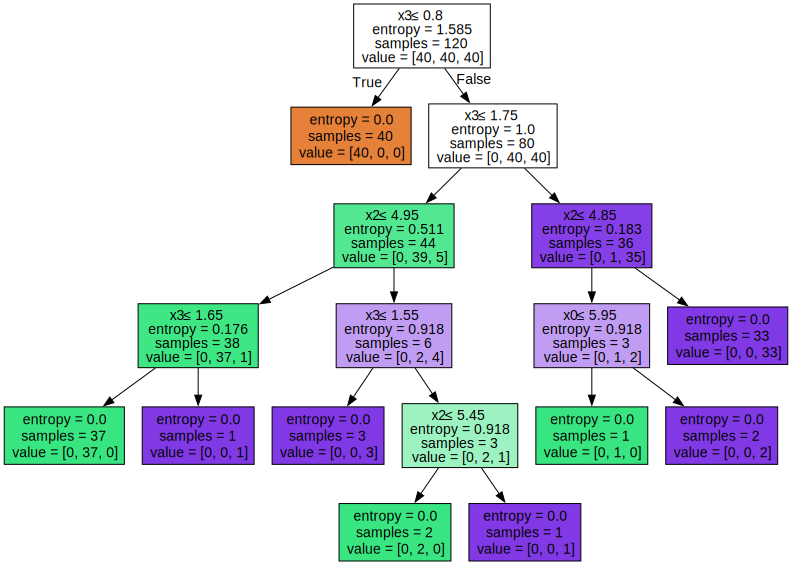

In [18]:
# 3-3. entropy
# 1)
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=11)
# 2)
model_entropy.fit(X_train, y_train)
# 3)
export_graphviz(model_entropy, out_file='iris_dt_model_entropy.dot', filled=True, special_characters=True)
# 4)
gv.Source.from_file('iris_dt_model_entropy.dot')

4. 모델 성능 평가

In [22]:
# .score
print('model entropy score :', model_entropy.score(X_train, y_train))
print('model entropy score :', model_entropy.score(X_test, y_test))
# 1.0 1.0 ??

model entropy score : 1.0
model entropy score : 1.0


In [39]:
# 모델 조합 조건 : GridSearchCV 활용
# - DT h-parameters : max_depth ...
from sklearn.model_selection import GridSearchCV
dt_model = DecisionTreeClassifier()
# 1) Set parameters
n_cv = 5
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 6]
}

# 2) Set GSCV Module
grid_search = GridSearchCV(dt_model, params, cv=n_cv)

# 3) Training
result = grid_search.fit(X_train, y_train)

# 4) Read .cv_results_ by DataFrame
cv_result = pd.DataFrame(result.cv_results_)
cv_result.sort_values(by='rank_test_score').head(3)   # 3^3 = 27가지 결과 출력

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.001794,0.000413,0.001199,0.000400,gini,10,2,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.000000,0.958333,0.958333,0.916667,0.916667,0.950000,0.031180,1
7,0.001599,0.000489,0.001200,0.000400,gini,15,3,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",1.000000,0.958333,0.958333,0.875000,0.916667,0.941667,0.042492,2
4,0.003406,0.001858,0.002199,0.000749,gini,10,3,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.958333,0.958333,0.875000,0.916667,0.933333,0.033333,3


In [41]:
# 5) Best result : params, score
print('Best params :', grid_search.best_params_)
print('Best score :', grid_search.best_score_)

# 6) Save Best result
best_model = grid_search.best_estimator_

Best params : {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best score : 0.95


<hr>


6. 학습 및 튜닝 후 모델 저장
- 다른 파일에서 활용이 가능한 파일 형태로 저장
- 앱, 웹 원하는 곳에서 활용 가능
- sklearn에선 pickle 포맷으로 저장
- joblib 모듈에 해당 기능 포함

In [43]:
# 1. Load Module
import os
import joblib

# 2. Save Model
model_dir = '../models/'
model_filename = model_dir + 'iris_dt_best_model.pkl'

# Check if the folder exists, otherwise create
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

joblib.dump(best_model, model_filename)

['../models/iris_dt_best_model.pkl']

In [ ]:
# Fin. go to use_model.py